# Explore `sentence_transformers`
Since Mon. Dec. 6th, 2021


Try `sentence_transformers` package for fine-tuning bi-encoders.




## Colab setup



In [8]:
import sys


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    ! pip3 install icecream datasets sentence-transformers

    import os
    os.chdir("/content/drive/My Drive//Research/Unified Encoder/Unified-Encoder")

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    ! echo $CUBLAS_WORKSPACE_CONFIG



## Setup



In [9]:
import math
import os
import shutil
import random

import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, InputExample, models, losses, evaluation
from icecream import ic

from util import *


rcParams["figure.dpi"] = 200
rcParams['font.size'] = 6


seed = config('random-seed')
random.seed(seed)
np.random.seed(seed)
if get_torch_device() == 'cuda':
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Required for some CuBLAS operations
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)


name_tune = 'eg_sbert'
d_tune = config(f'fine-tune.{name_tune}')
d_dset = config(f'datasets.{d_tune["dataset_name"]}')
md_path = os.path.join(PATH_BASE, DIR_PROJ, DIR_MDL, name_tune)



## Set up model



In [10]:
base = models.Transformer(d_tune['embedding_model_name'], max_seq_length=d_tune['max_seq_length'])
pool = models.Pooling(base.get_word_embedding_dimension(), **d_tune['pooling_model_kwargs'])
model = SentenceTransformer(modules=[base, pool])



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Prep Data


In [11]:
dnm = d_tune['dataset_name']

dset = load_dataset(dnm, name='en').shuffle(seed=seed)
ic(d_dset)
for nm, ds in dset.items():
    assert len(ds) == d_dset['n_sample'][nm]

dset_ = dict()
ran = d_dset['label_range']
ran = ran['max'] - ran['min']
for nm, ds in dset.items():
    dset_[nm] = [InputExample(texts=[eg['sentence1'], eg['sentence2']], label=eg['similarity_score'] / ran) for eg in ds][:80]



Reusing dataset stsb_multi_mt (/Users/stefanh/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9/cache-5015801d0d574272.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9/cache-aed9104de7b4bf7c.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9/cache-09d174b054d294eb.arrow
ic| d_dset: {'label_range': {'max': 5, 'min': 0},
             'n_sample': {'dev': 1500, 'test': 1379, 'train': 5749}}


## Sanity check
The raw performance should be worse than that after training



In [12]:
test_eval = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(
    dset_['test'], name=f'{dnm}, test', main_similarity=evaluation.SimilarityFunction.COSINE
)
perf_raw = test_eval(model)
ic(perf_raw)



ic| perf_raw: 0.631189729186081


0.631189729186081

## Train


In [13]:
dl_train = DataLoader(dset_['train'], shuffle=True, batch_size=d_tune['batch_size'], worker_init_fn=seed_worker)
n_step = len(dl_train) * d_tune['n_epochs']
# l_eval_step = round(n_step / d_tune['n_eval'], -1)  # Multiples of 10^1
# ic(l_eval_step)
l_eval_step = 1

eval_nm = f'{dnm}, dev'
eval_fnm = f'similarity_evaluation_{eval_nm}_results.csv'

if os.path.exists(md_path):
    shutil.rmtree(md_path)
model.fit(
    train_objectives=[
        (dl_train, losses.CosineSimilarityLoss(model))
    ],
    # epochs=d_tune['n_epochs'],
    epochs=1,
    warmup_steps=math.ceil(n_step * d_tune['warmup_frac']),
    evaluator=evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dset_['dev'], name=eval_nm),
    evaluation_steps=l_eval_step,
    output_path=md_path
)



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

## Evaluate


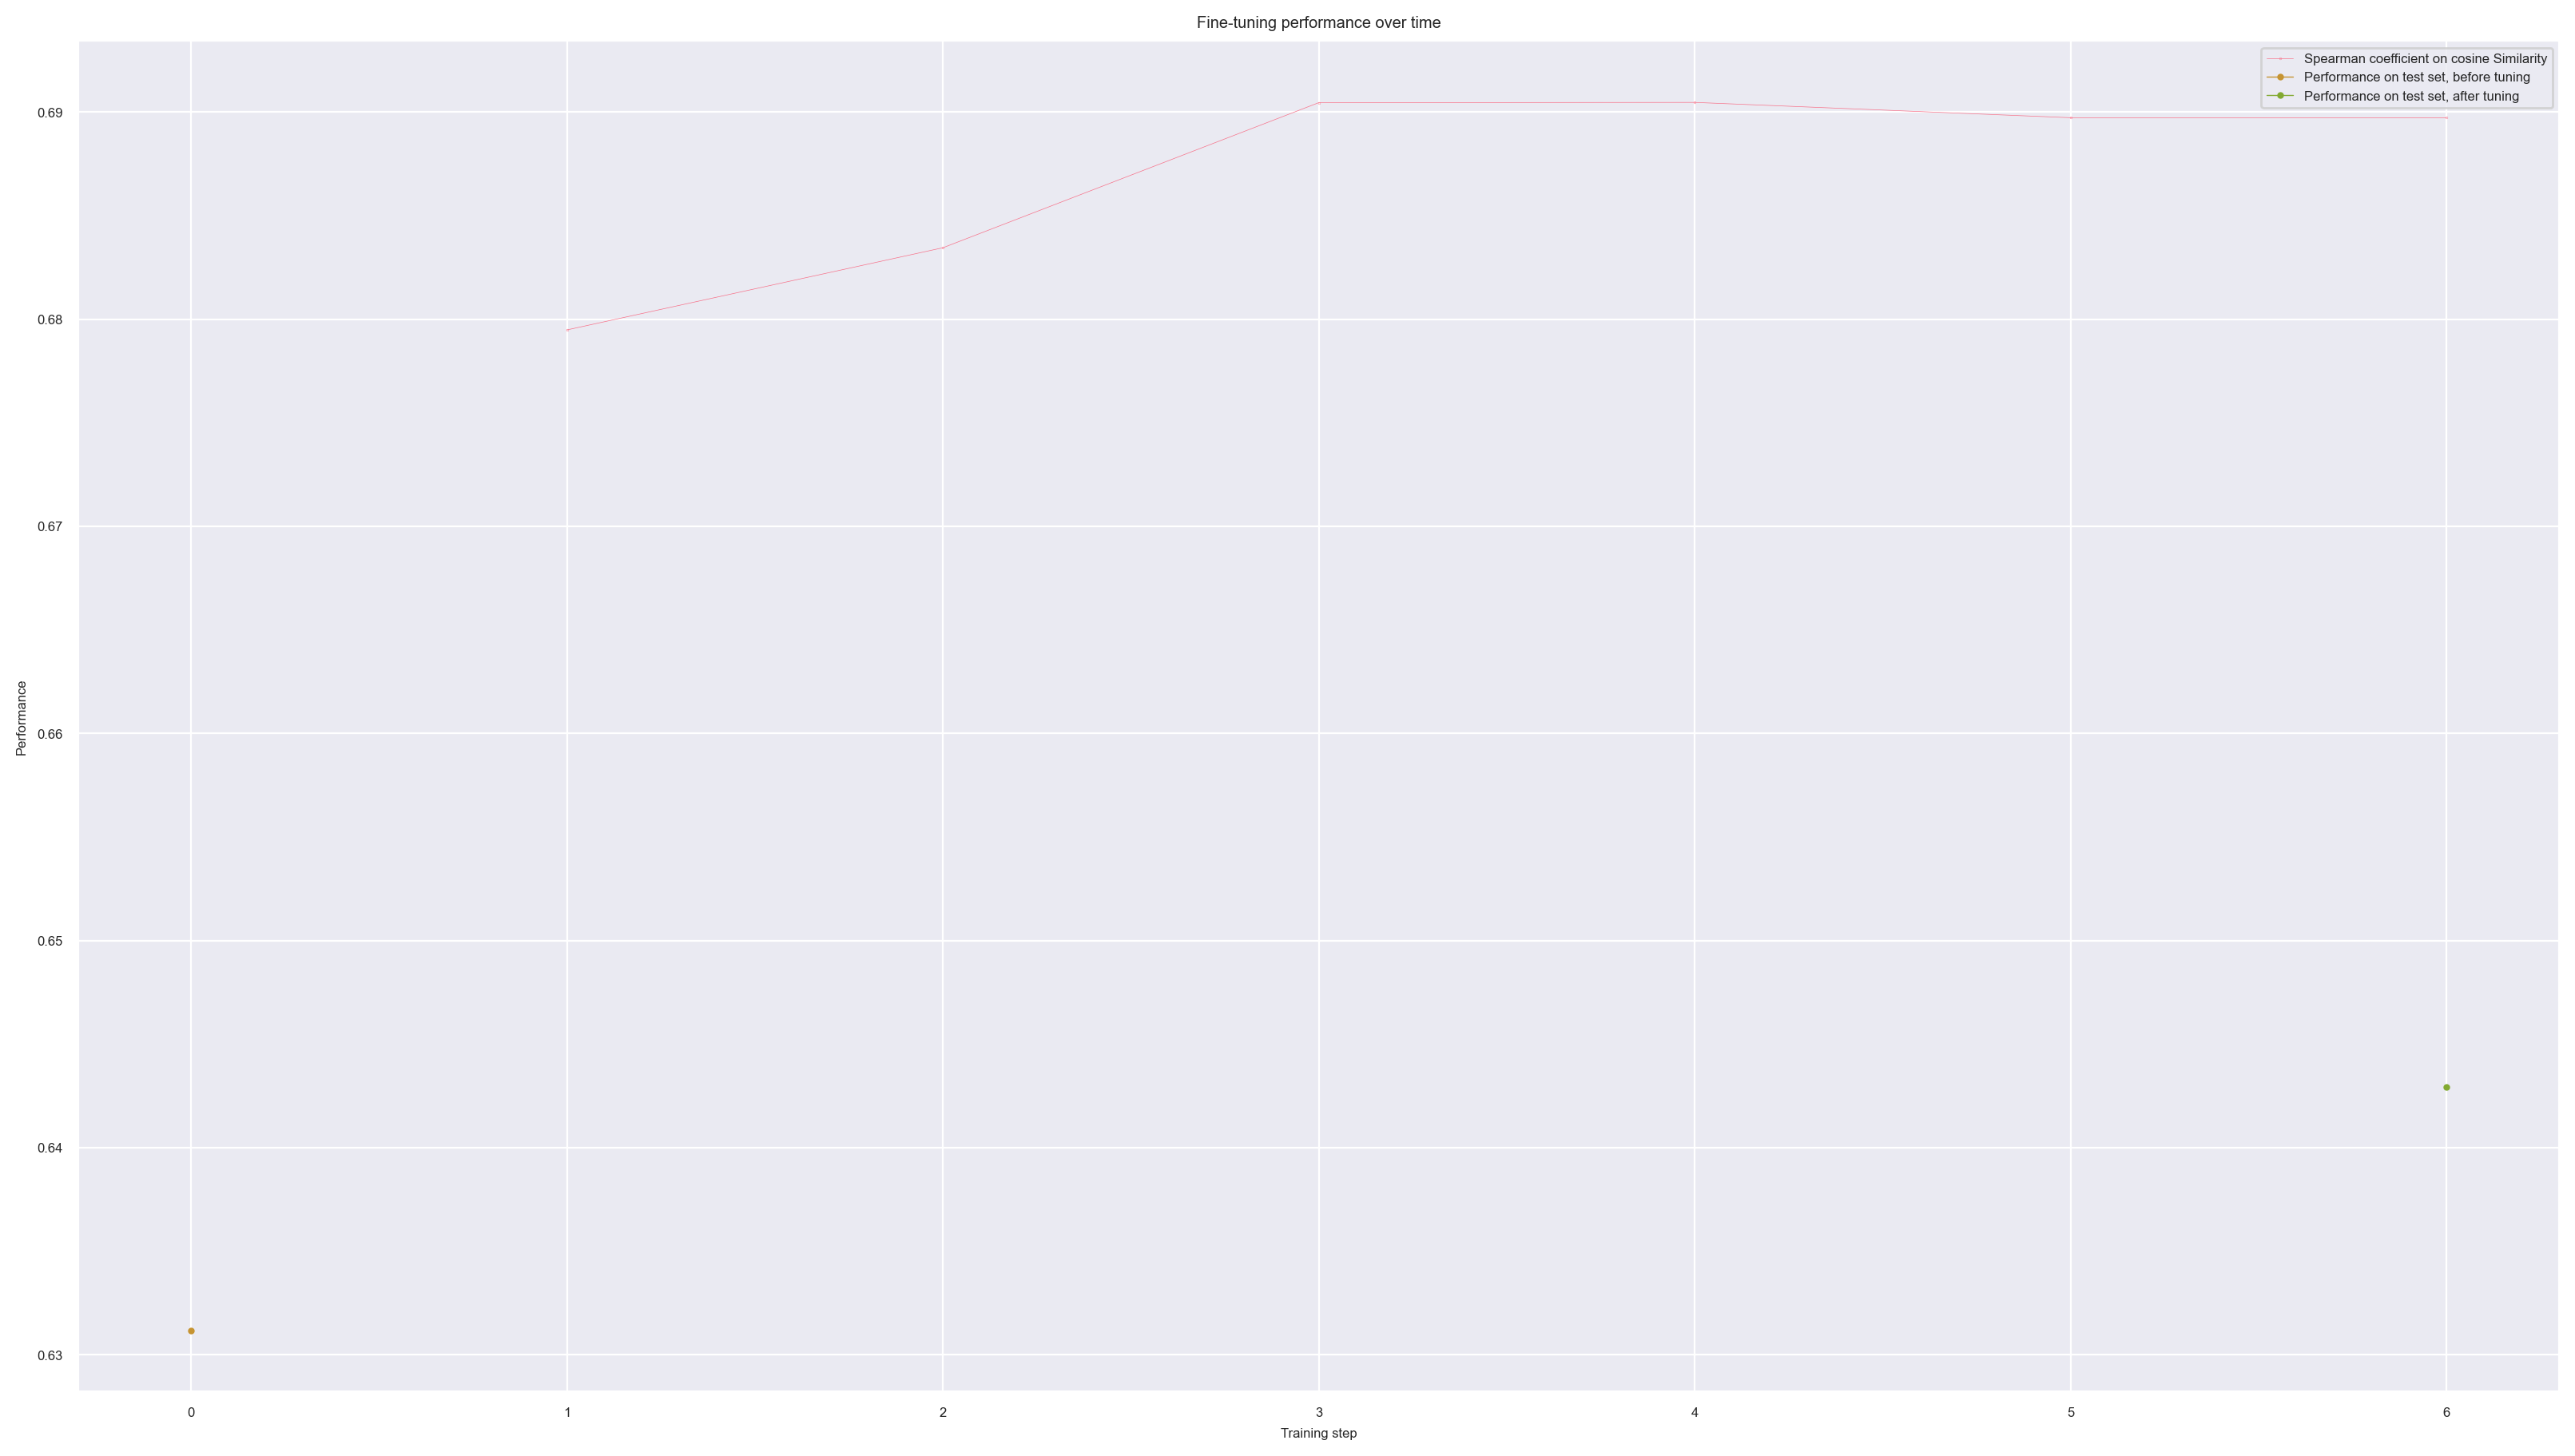

In [14]:
import pandas as pd
df = pd.read_csv(os.path.join(md_path, 'eval', eval_fnm))
perfs = df['cosine_spearman']  # An additional row saved after training completion by `fit`

cs = iter(sns.color_palette(palette='husl', n_colors=7))
plt.figure(figsize=(16, 9))
steps = (np.arange(len(perfs))+1) * l_eval_step
plt.plot(steps, perfs, marker='.', lw=0.25, ms=0.3, c=next(cs), label='Spearman coefficient on cosine Similarity')
plt.xlabel('Training step')
plt.ylabel('Performance')
plt.title('Fine-tuning performance over time')


model = SentenceTransformer(md_path)
path = os.path.join(md_path, 'eval, test')
os.makedirs(path, exist_ok=True)
perf = test_eval(model, output_path=path)
plot_points([(0, perf_raw)], ms=4, c=next(cs), label='Performance on test set, before tuning')
plot_points([(steps[-1], perf)], ms=4, c=next(cs), label='Performance on test set, after tuning')
plt.legend()
plt.show()

